In [ ]:
## Time Division

In [9]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import datetime as dt
import math

# 시각화 관련
import plotly_express as px
import plotly.figure_factory as ff
import cufflinks as cf
cf.go_offline(connected=True)
## cf.getThemes()
cf.set_config_file(theme='polar')
import plotly.graph_objects as go
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
## plt.style.use("fivethirtyeight")
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams["figure.figsize"] = (10,6)


## 퀀트함수 ## 절대경로 참조
import sys, os
sys.path.append(os.path.dirname(os.path.abspath(os.path.dirname('__file__'))))
from library.quant_functions import anal_funcs, data_funcs

## Func

In [10]:
## 동일 가중 시분할 시뮬레션
def get_INDI(df_ori, folw, terms = 120, seed = 0, fx= 1300):
    '''
    df: 종가데이터
    seed: 초기투자금
    folw: 월납입액
    fx: 달러원환율
    '''
    folw = folw*fx
    seed = seed*fx
    tickers = list(df_ori.columns)
    df_clean = df_ori.dropna()
    df_clean = df_clean.resample('M').last()
    dfs = [df_clean[i:i+terms] for i in range(len(df_clean)-terms+1)]
    _ls = []
    ## 역사적 시뮬레이션
    for df in dfs:
        for ticker in tickers:
            df[f"{ticker}_quant"] = (float(folw)/df[ticker]).apply(lambda x:math.floor(x))
            df[f"{ticker}_cost"] = df[ticker] * df[f"{ticker}_quant"]
            df[f"{ticker}_cquant"] = df[f"{ticker}_quant"].cumsum()
            df[f"{ticker}_cquant"] = df[f"{ticker}_cquant"] + math.floor(seed/df[ticker][0])
            df[ticker] = df[ticker] * df[f"{ticker}_cquant"]
        df = df[tickers]

        _ls.append(df.reset_index(drop=True))
    result = pd.concat(_ls, axis=1)
    
    ## 통계량 도출: 몬테카를로
    _stats = []
    for ticker in tickers:
        stat = pd.concat([result[ticker].mean(axis=1), result[ticker].min(axis=1), result[ticker].max(axis=1), result[ticker].std(axis=1)], axis=1)
        stat.columns = ['mean', 'min', 'max', 'std']
        
        stat['s2+'] = stat['mean'] + 2*stat['std']
        stat['s2-'] = stat['mean'] - 2*stat['std']
        stat['s3+'] = stat['mean'] + 3*stat['std']
        stat['s3-'] = stat['mean'] - 3*stat['std']
        
        _stats.append(stat.drop(columns='std'))
    
    return result[tickers], dict(zip(tickers, _stats))

## Proc

In [76]:
## 원천데이터 불러옴
## df_ori = get_merged_df('^IXIC', '^GSPC')
df_ori = data_funcs.get_merged_df('QQQ', 'QLD', 'TQQQ', 'SHY', 'IEF', 'TLT', 'TMF')
df_ori = df_ori[['QQQ', 'QLD', 'TQQQ', 'SHY', 'IEF', 'TLT', 'TMF']]
## 무위험자산
df_ori['CASH'] = [(1+0.03)**(n/250) for n in range(len(df_ori))]

[*********************100%***********************]  7 of 7 completed


In [77]:
df_indi, stats = get_INDI(df_ori[:], 285, int(12*5+2), 35000)
## df_indi, stats = get_INDI(df_ori[:], 120*1250, int(12*15), 0)

In [78]:
X1, X2, X3 = 'QQQ', 'QLD', 'TQQQ'

data = pd.concat([stats[X1]['mean'], stats[X1]['min'], stats[X1]['max'],
                  stats[X2]['mean'], stats[X2]['min'], stats[X2]['max'],
                  stats[X3]['mean'], stats[X3]['min'], stats[X3]['max'],
                  stats['CASH']['mean']], axis=1)

data.columns = ['X1', 'X1_min', 'X1_max',
                'X2', 'X2_min', 'X2_max', 
                'X3', 'X3_min', 'X3_max',
                'rf']

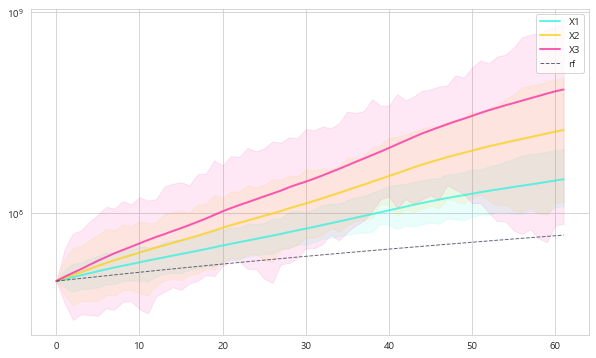

In [104]:
fig, ax = plt.subplots(figsize=(10,6))
line1 = ax.plot(data.index, data['X1'],
        color="#2FF3E0", alpha=0.75, label="X1", linewidth=2)
fill1 = ax.fill_between(data.index, data['X1_min'], data['X1_max'], color = '#2FF3E0', alpha=0.1)

line2 = ax.plot(data.index, data['X2'],
        color="#F8D210", alpha=0.75, label="X2", linewidth=2)
fill2 = ax.fill_between(data.index, data['X2_min'], data['X2_max'], color = '#F8D210', alpha=0.1)

line3 = ax.plot(data.index, data['X3'],
        color="#FA26A0", alpha=0.75, label="X3", linewidth=2)
fill3 = ax.fill_between(data.index, data['X3_min'], data['X3_max'], color = '#FA26A0', alpha=0.1)

line_base = ax.plot(data.index, data['rf'],
        color="#333652", alpha=0.75, label="rf", linewidth=1, linestyle= '--')


plt.yscale('log')
plt.legend()
plt.show()

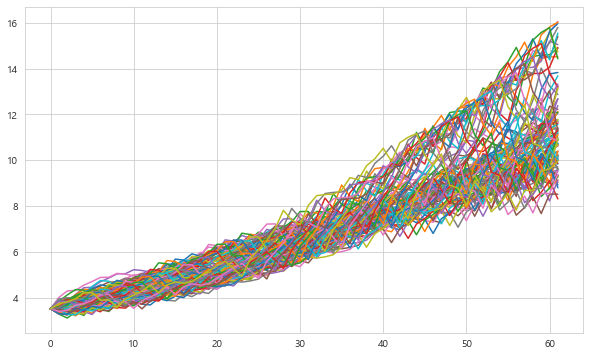

In [61]:
(df_indi[X1]/1300/1e4).plot()
plt.legend().set_visible(False)